In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import gzip
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import word_tokenize, pos_tag


#force output to display the full description
pd.set_option('display.max_colwidth', -1)


/var/folders/h5/6b6s2cwd2m19kydv6p77mmdh0000gn/T/ipykernel_879/2744649045.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [55]:
# 1. Wordcloud of Top N words in each topic
#Adapted from source: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def build_wordcloud(lda_model):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

    return

In [2]:
df = pd.read_csv('data/reviews_authors_genres.csv') 

In [3]:
#Remove neutral reviews 
df = df[df['rating'] !=3] 

In [4]:
lan = ['eng','en-GB','en-US','en-CA', 'en']
df = df[df['language_code'].isin(lan)] 


In [5]:
#creating a copy of the dataframe to clean and preprocess.
df2 = df.copy()

#drop na's from the dataframe.
df2.dropna(inplace=True)

In [6]:
def set_sentiment(c):
    if c == 'bad':
        return 0
    else:
        return 1
    

df2['sentiment'] =df2['sentiment'].apply(set_sentiment)

In [7]:
df2.head()

,Unnamed: 0,book_id,review_text,rating,sentiment,language_code,authors,author_id,author_names,genres
12,12,11101181,"This has got to be the most ridiculous book I have ever read. Mostly for the plethora of basic historical mistakes that could have been checked with a 5 minutes google search. \n Ms McCray has the citizens of Republican Rome (BCE) eating tomatoes and potatoes and knowing about chocolate (these items didn't arrive in Europe until the late 16th century) and pasta (it didn't arrive in Italy until Marco Polo returned from China in the late 13th century). \n Also, Ms. McCray obviously has no idea about the naming protocol in Rome. Julius wasn't Caesar's first name it was his last name and his daughter was Julia, not his wife. \n And why did she feel the need to rename Brutus's wife and mother. They were hardly unknown. His wife was Porcia Catonis and his mother the famous Servillia. \n I would not recommend this book to anyone and would give it -5 stars if I could.",1,0,eng,"[{'author_id': '4127933', 'role': ''}]",['4127933'],['Carolyn McCray'],"['romance', 'fantasy, paranormal', 'fiction', 'history, historical fiction, biography', 'mystery, thriller, crime']"
21,21,9688325,"Cal is a lust demon. He is has been around for a long time. He is seen as a 'good' demon, because he uses his ability to play matchmaker. Though he is a romantic at heart, he (knows) he isn't meant to find a mate. Because a mate would have to be okay with his way of life. In comes Gabe, a (virgin) Fae. Ends up Gabe was sent to be Cal's mate. Gabe is a special type of Fae and his kind is very rare. Cal was chosen and Gabe is quite alright with it. As they work out their relationship, their are halflings(not good) who are out in the city who are after not just Gabe but other (innocents). \n This story was okay. I was something to pass the time with but something I'd probably want to reread. Just reading the summary was enough to recall the story. Though, I am likely to continue series, it a series I want to jump right into the next one...",2,0,eng,"[{'author_id': '3500215', 'role': ''}]",['3500215'],['Joyee Flynn'],"['fantasy, paranormal', 'romance', 'fiction']"
23,23,6378776,Great book!,0,0,en-GB,"[{'author_id': '40311', 'role': ''}]",['40311'],['Piers Paul Read'],"['fiction', 'mystery, thriller, crime', 'history, historical fiction, biography']"
25,25,12476820,Didn't grab my attention. May pick it back up later.,0,0,en-US,"[{'author_id': '2740668', 'role': ''}]",['2740668'],['Dan Wells'],"['young-adult', 'fiction', 'fantasy, paranormal', 'romance', 'mystery, thriller, crime']"
34,34,10943536,Liked the writingstyle and the first part of the book but then it changed so suddenly i had no idea what was happening as if i was reading a different book. But still love sherlock.,2,0,eng,"[{'author_id': '2448', 'role': ''}]",['2448'],['Arthur Conan Doyle'],"['mystery, thriller, crime', 'fiction', 'history, historical fiction, biography']"


In [8]:
df2['word_count'] = df2['review_text'].apply(lambda x: len(str(x).split(" ")))


In [9]:
print("Word Count Median: " + str(df2['word_count'].median()))
print(df2['word_count'].describe())


Word Count Median: 57.0
count    76828.000000
mean     121.144674  
std      181.905803  
min      1.000000    
25%      21.000000   
50%      57.000000   
75%      146.000000  
max      3895.000000 
Name: word_count, dtype: float64


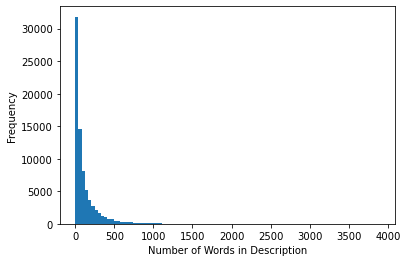

In [10]:
x = df2['word_count']

n_bins = 95
plt.hist(x, bins=n_bins)
plt.xlabel('Number of Words in Description')
plt.ylabel('Frequency')
plt.show()

2.0
count    14408.000000
mean     2.546155    
std      1.967235    
min      0.000000    
25%      0.000000    
50%      2.000000    
75%      4.000000    
max      5.000000    
Name: rating, dtype: float64


Text(0.5, 1.0, 'Ratings count for word count less than 15')

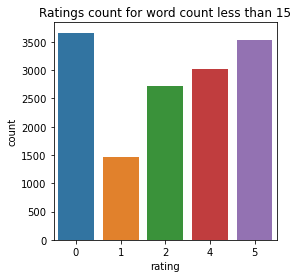

In [60]:
#Ratings for word counts less than 15
wc15 = df2.loc[df2['word_count'] < 15]
print(wc15.rating.median())
print(wc15.rating.describe())

#plot the counts
plt.figure(figsize=(4,4))
sns.countplot(x ='rating', data = wc15).set_title("Ratings count for word count less than 15")

4.0
count    33676.000000
mean     3.139357    
std      1.615230    
min      0.000000    
25%      2.000000    
50%      4.000000    
75%      5.000000    
max      5.000000    
Name: rating, dtype: float64


Text(0.5, 1.0, 'Ratings count for word count greater than 70')

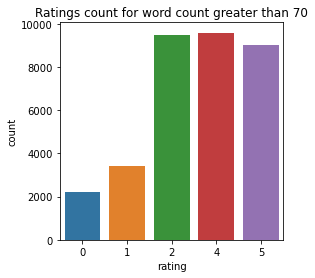

In [62]:
#Ratings word counts greater than 70
wc70 = df2.loc[df2['word_count'] > 70]
print(wc70.rating.median())
print(wc70.rating.describe())
#plot the counts
plt.figure(figsize=(4,4))
sns.countplot(x ='rating', data = wc70).set_title("Ratings count for word count greater than 70")

Number of Unique Ratings: 5
Rating Median: 4.0
count    76872.000000
mean     2.943621    
std      1.748521    
min      0.000000    
25%      2.000000    
50%      4.000000    
75%      5.000000    
max      5.000000    
Name: rating, dtype: float64


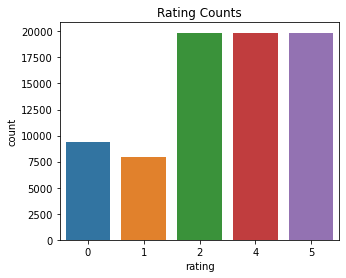

In [79]:
print("Number of Unique Ratings: " + str(len(df['rating'].unique())))
print("Rating Median: " + str(df['rating'].median()))
print(df['rating'].describe())
plt.figure(figsize=(5,4))
sns.countplot(x='rating', data=df).set_title("Rating Counts")
plt.show()
#add column to flag records with rating greater than 88
df['above_avg'] = [1 if rating > 88 else 0 for rating in df['rating']]

In [14]:
df2['review_text'].iloc[1678]

'This was definitely not my favorite disc world book. I was disappointed. I generally listen to all the disc world novels via audiobook (I love the narrators Nigel Planer and Steven Briggs), but I spent many hours waiting for this one to make me laugh as most of the series do.'

In [15]:
#A contractions dictionary from Wikipedia found on Stack Overflow for expanding contractions: 
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_dict = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [16]:
import re

#This code is code to expand contractions in text created by Abhishek Sharma:
#https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

#Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

#Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)



In [17]:
#create a list of stop words
stemmer = SnowballStemmer('english')
stopwords_list = stopwords.words("english")
stopwords_list.extend(['book','story','author','character','cannot','like','liked,','today','','one','really','read','reading','would','much','que','reviewed','rating','get','first','got','could','time','way','put','feel','felt','next','see','still','another','ever','thing', 'know', 'think', 'even', 'want', 'make', 'going',])
stopwords_list.extend(['love','loved','review','come','plot','found','cant','give','maybe','also','actual'])
stopwords_list.extend(['also', 'two', 'well', 'go', 'say', 'lot','de', 'la', 'el', 'en', 'un', 'se', 'lo', 'libro', 'una', 'los','thought','written'])
stop_words = set(stopwords_list)
#show how many words are in the list of stop words
print(len(stop_words))
#179
#construct a new list to store the cleaned text
clean_desc = []


for w in range(len(df2.review_text)):
#     print(w)
#   
    desc = df2['review_text'].iloc[w].lower()
    
#     remove URLS
    desc = re.sub('https:\/\/.*|http:\/\/.*', '', desc)

# Expanding Contractions in the reviews
    desc = expand_contractions(desc)

#removing all newline '\n' characters
    desc = re.sub(r'\n',' ', desc) 

    #remove punctuation
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    
    #remove tags
    desc = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
    
    #remove special characters and digits
    desc = re.sub("(\\d|\\W)+"," ",desc)
    
    #removing all excess space.
    desc = re.sub('\s+',' ',desc)

    split_text = desc.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
#     split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words and len(word) >2] 
    split_text = [stemmer.stem(lem.lemmatize(word)) for word in split_text if not word in stop_words and len(word) >2]
    split_text = " ".join(split_text)
    clean_desc.append(split_text)

245


In [18]:
df2[df2['rating'] ==0].head(30)


,Unnamed: 0,book_id,review_text,rating,sentiment,language_code,authors,author_id,author_names,genres,word_count
23,23,6378776,Great book!,0,0,en-GB,"[{'author_id': '40311', 'role': ''}]",['40311'],['Piers Paul Read'],"['fiction', 'mystery, thriller, crime', 'history, historical fiction, biography']",2
25,25,12476820,Didn't grab my attention. May pick it back up later.,0,0,en-US,"[{'author_id': '2740668', 'role': ''}]",['2740668'],['Dan Wells'],"['young-adult', 'fiction', 'fantasy, paranormal', 'romance', 'mystery, thriller, crime']",10
53,53,25752041,"To whoever wrote this book's ""synopsis"": \n syn*op*sis \n /s@'naps@s/ \n noun \n - a brief summary or general survey of something. \n Do take note.",0,0,eng,"[{'author_id': '14112744', 'role': ''}]",['14112744'],['Andrew Shvarts'],"['fantasy, paranormal', 'young-adult', 'romance', 'fiction', 'history, historical fiction, biography']",26
64,64,2320230,Teju cole,0,0,eng,"[{'author_id': '1042875', 'role': ''}]",['1042875'],['Teju Cole'],"['fiction', 'non-fiction']",2
71,71,79121,Beautiful stories!,0,0,eng,"[{'author_id': '3565', 'role': ''}]",['3565'],['Oscar Wilde'],"['fiction', 'fantasy, paranormal', 'children', 'young-adult', 'history, historical fiction, biography']",2
238,238,111595,"About the book: WANTED FOR KIDNAPPING: a beautiful blonde with a penchant for trouble. May be armed (with bad intentions) and dangerously seductive... \n Kerry Sullivan is running out of time--and patience. With her brother wrongfully accused of embezzling millions, she can't face one more humiliating hang up from the man she's begging for help. Rafael Dawson may be one of the top electronic security experts in the country--and the only man who can prove her brother's innocence--but his phone manners are appalling. Damn Yankee. Too bad kidnapping the man isn't an option. Or is it? \n There's nothing Kerry wouldn't do for her brother. There are lots of things she longs to do to Rafe Dawson when he's lying tied up and naked in Kerry's secret hideaway. Rafe is certainly something to look at, but her brother's life is riding on her pulling off the impossible: getting this man who's always in control to lose it. But when the tables are turned, Kerry finds herself at Rafe's mercy. And the only way to get her way is to let him have his way--with her... \n Review: The book intrigued me from the start. I was guessing about the guilty party along with the main characters and was actually surprised in the end by the revelation. That earns the book another star. Characters were likeable and I wished them all a HEA. \n A decent read for sure.",0,0,eng,"[{'author_id': '21933', 'role': ''}, {'author_id': '20983', 'role': ''}]","['21933', '20983']","['Shelley Bradley', 'Shayla Black']","['romance', 'fiction', 'mystery, thriller, crime']",238
277,277,29939303,"I do not remember reading any book that is more depressing than this one. Possibly Flannery O'Conner, but those are shorter. This one starts with parents arguing about selling their child into slavery and gets grimmer from there. I kinda feel like I've been hit in the head.",0,0,eng,"[{'author_id': '4023684', 'role': ''}]",['4023684'],['Thoraiya Dyer'],"['fantasy, paranormal', 'fiction', 'young-adult']",48
317,317,17738298,"""I enjoyed this book by Catherine. This book includes passion, laughs, heartache, and an abandoned baby."" from a harlequin.com member review, to read the full review, go HERE> http://www.harlequin.com/storeitem.ht...",0,0,eng,"[{'author_id': '93454', 'role': ''}]",['93454'],['Catherine Mann'],"['romance', 'fiction']",29
349,349,7989713,False,0,0,en-US,"[{'author_id': '10838', 'role': ''}, {'author_id': '551614', 'role': 'Translator'}]","['10838', '551614']","['Ismail Kadare', 'John Hodgson']","['fiction', 'mystery, thriller, crime', 'poetry']",1
391,391,9684523,"** spoiler alert ** \n Good historical details, but I was a bit disappointed. This book really needs a glossary.",0,0,eng,"[{'author_id': '211268', 'role': ''}]",['211268'],['G

In [19]:
#TF-IDF vectorizer
tfv = TfidfVectorizer(stop_words = stop_words, ngram_range = (1,1))
#transform
vec_text = tfv.fit_transform(clean_desc)
#returns a list of words.
words = tfv.get_feature_names()


/Users/aanyaashi/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['liked'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [20]:
#setup kmeans clustering
kmeans = KMeans(n_clusters = 10, n_init = 17,  tol = 0.01, max_iter = 200)
#fit the data 
kmeans.fit(vec_text)
#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]

for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))


0 : enjoy, fun, favorit, beauti, wait, better, dnf, star, best, write
1 : interest, charact, enjoy, good, end, write, seem, enough, page, littl
2 : finish, bore, start, charact, tri, page, never, seri, good, write
3 : good, charact, enjoy, end, pretti, write, littl, author, quick, better
4 : end, charact, enjoy, good, disappoint, start, happen, happi, star, bit
5 : charact, life, author, novel, write, peopl, good, enjoy, find, seem
6 : star, receiv, half, round, wish, final, deserv, full, follow, enjoy
7 : amaz, bore, fals, meh, wow, edit, charact, author, wait, sign
8 : seri, enjoy, charact, wait, end, good, favorit, better, start, continu
9 : great, charact, seri, enjoy, end, wait, good, recommend, fun, author


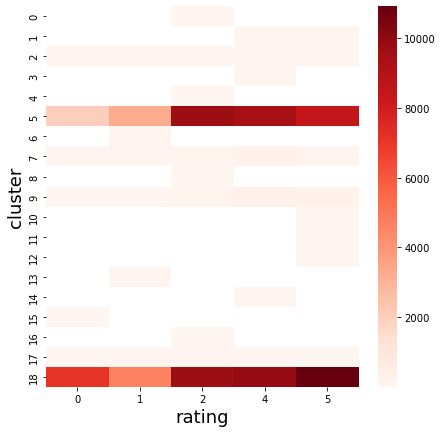

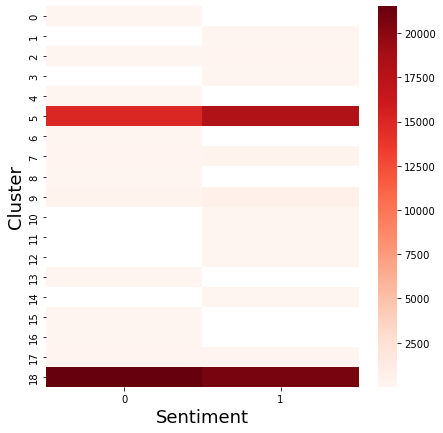

In [70]:
#add the cluster label to the data frame
df2['cluster'] = kmeans.labels_
clusters = df2.groupby(['cluster', 'rating']).size()
fig, ax1 = plt.subplots(figsize = (7, 7))
sns.heatmap(clusters.unstack(level = 'rating'), ax = ax1, cmap = 'Reds')
ax1.set_xlabel('rating').set_size(18)
ax1.set_ylabel('cluster').set_size(18)
clusters = df2.groupby(['cluster', 'sentiment']).size()
fig2, ax2 = plt.subplots(figsize = (7, 7))
sns.heatmap(clusters.unstack(level = 'sentiment'), ax = ax2, cmap="Reds")
ax2.set_xlabel('Sentiment').set_size(18)
ax2.set_ylabel('Cluster').set_size(18)

In [47]:
interia = [] 
for i in range(1, 20): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter=100, n_init=1,random_state = 42)
    kmeans.fit(vec_text) 
    interia.append(kmeans.inertia_)

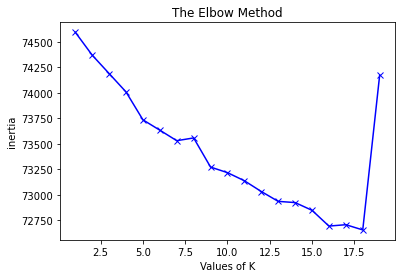

In [50]:

K = range(1, 20)
plt.plot(K, interia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('inertia')
plt.title('The Elbow Method')
plt.show()

In [26]:
#Starting LDA
# Adapted from Source: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aanyaashi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


In [28]:
clean_desc[4310]

'kira born fair ordinari parent third child special tiger spirit made demon hunter smell better reflex fight demon attack increas work human take seven kingdom kira must protect cousin princ convinc focus propheci defeat demon king korean influenc write pretti amateurish entir predict fight overdon write style gap storytel'

In [29]:
#Adding genism lemmatizing which seems to be removing additinal words
doc_sample = str(clean_desc[4310])
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['kira', 'born', 'fair', 'ordinari', 'parent', 'third', 'child', 'special', 'tiger', 'spirit', 'made', 'demon', 'hunter', 'smell', 'better', 'reflex', 'fight', 'demon', 'attack', 'increas', 'work', 'human', 'take', 'seven', 'kingdom', 'kira', 'must', 'protect', 'cousin', 'princ', 'convinc', 'focus', 'propheci', 'defeat', 'demon', 'king', 'korean', 'influenc', 'write', 'pretti', 'amateurish', 'entir', 'predict', 'fight', 'overdon', 'write', 'style', 'gap', 'storytel']


 tokenized and lemmatized document: 
['kira', 'bear', 'fair', 'ordinari', 'parent', 'child', 'special', 'tiger', 'spirit', 'demon', 'hunter', 'smell', 'better', 'reflex', 'fight', 'demon', 'attack', 'increa', 'work', 'human', 'seven', 'kingdom', 'kira', 'protect', 'cousin', 'princ', 'convinc', 'focus', 'propheci', 'defeat', 'demon', 'king', 'korean', 'influenc', 'write', 'pretti', 'amateurish', 'entir', 'predict', 'fight', 'overdon', 'write', 'style', 'storytel']


In [30]:

df_clean_desc = pd.DataFrame(clean_desc, columns =['review_text'])
processed_docs = df_clean_desc['review_text'].map(preprocess)
processed_docs[:10]

0    [ridicul, plethora, basic, histor, mistak, check, minut, googl, search, mccray, citizen, republican, rome, tomato, potato, know, chocol, item, arriv, europ, late, centuri, pasta, arriv, itali, marco, polo, return, china, late, centuri, mccray, obvious, idea, protocol, rome, julius, caesar, daughter, julia, wife, need, renam, brutus, wife, mother, hard, unknown, wife, porcia, catoni, mother, famous, servillia, recommend, anyon, star]                                                                                                                                                                                                                      
1    [lust, demon, long, see, good, demon, abil, play, matchmak, romant, heart, know, mean, mate, mate, okay, life, come, gabe, virgin, gabe, send, mate, gabe, special, type, kind, rare, choos, gabe, quit, alright, work, relationship, halfl, good, citi, gabe, innoc, okay, someth, someth, probabl, reread, summari, recal, like, continu, seri, s

In [31]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 anyon
1 arriv
2 basic
3 brutus
4 caesar
5 catoni
6 centuri
7 check
8 china
9 chocol
10 citizen


In [33]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
# bow_corpus[4310]

[(55, 3),
 (84, 1),
 (88, 1),
 (163, 2),
 (190, 1),
 (276, 1),
 (295, 1),
 (387, 1),
 (431, 1),
 (444, 1),
 (480, 1),
 (521, 2),
 (582, 1),
 (631, 1),
 (714, 1),
 (742, 1),
 (755, 1),
 (946, 1),
 (965, 1),
 (1012, 1),
 (1169, 1),
 (1214, 1),
 (1326, 1),
 (1415, 1),
 (1536, 1),
 (1722, 1),
 (1728, 1),
 (2000, 1),
 (2129, 1),
 (2338, 1),
 (2388, 1),
 (2820, 1),
 (2860, 1),
 (2947, 1),
 (6276, 1),
 (7536, 2),
 (9334, 1),
 (10959, 1),
 (11737, 1)]

In [34]:
# Preview Bag Of Words for our sample preprocessed document.
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 55 ("demon") appears 3 time.
Word 84 ("special") appears 1 time.
Word 88 ("work") appears 1 time.
Word 163 ("write") appears 2 time.
Word 190 ("better") appears 1 time.
Word 276 ("human") appears 1 time.
Word 295 ("tiger") appears 1 time.
Word 387 ("entir") appears 1 time.
Word 431 ("style") appears 1 time.
Word 444 ("attack") appears 1 time.
Word 480 ("smell") appears 1 time.
Word 521 ("fight") appears 2 time.
Word 582 ("pretti") appears 1 time.
Word 631 ("focus") appears 1 time.
Word 714 ("kingdom") appears 1 time.
Word 742 ("child") appears 1 time.
Word 755 ("king") appears 1 time.
Word 946 ("amateurish") appears 1 time.
Word 965 ("fair") appears 1 time.
Word 1012 ("parent") appears 1 time.
Word 1169 ("predict") appears 1 time.
Word 1214 ("convinc") appears 1 time.
Word 1326 ("bear") appears 1 time.
Word 1415 ("protect") appears 1 time.
Word 1536 ("defeat") appears 1 time.
Word 1722 ("seven") appears 1 time.
Word 1728 ("spirit") appears 1 time.
Word 2000 ("cousin") appears 1 ti

In [35]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# from pprint import pprint
# for doc in corpus_tfidf:
#     pprint(doc)
#     break


[(0, 0.06129803271142268),
 (1, 0.18116954813370212),
 (2, 0.07019923723501074),
 (3, 0.20927813911867796),
 (4, 0.15450091993428702),
 (5, 0.20927813911867796),
 (6, 0.172490525512316),
 (7, 0.07784805804435016),
 (8, 0.11593857960488546),
 (9, 0.11497817961049939),
 (10, 0.1136245923480554),
 (11, 0.07366500665858036),
 (12, 0.11196059057708113),
 (13, 0.09244005150008144),
 (14, 0.1144021701804024),
 (15, 0.04950634487371777),
 (16, 0.07333773564872002),
 (17, 0.055815918409421024),
 (18, 0.1200590818594401),
 (19, 0.11774869141607855),
 (20, 0.11474563135243676),
 (21, 0.15657011920670005),
 (22, 0.04770741372216882),
 (23, 0.1562407000901621),
 (24, 0.14210200018108265),
 (25, 0.37767995065112425),
 (26, 0.08213898800543422),
 (27, 0.08501342476876157),
 (28, 0.12766906134565062),
 (29, 0.04517297506021548),
 (30, 0.06936448458564388),
 (31, 0.17059300218234705),
 (32, 0.14112263625192015),
 (33, 0.1759449296801185),
 (34, 0.20927813911867796),
 (35, 0.13613195541358428),
 (36, 0.

In [36]:
# Running LDA using bag of words
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)


In [37]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"life" + 0.008*"world" + 0.007*"child" + 0.006*"human" + 0.006*"young" + 0.006*"novel" + 0.006*"year" + 0.006*"peopl" + 0.005*"live" + 0.004*"reader"
Topic: 1 
Words: 0.009*"life" + 0.007*"want" + 0.007*"friend" + 0.006*"heart" + 0.006*"seri" + 0.006*"girl" + 0.005*"come" + 0.005*"start" + 0.005*"need" + 0.005*"know"
Topic: 2 
Words: 0.021*"charact" + 0.014*"seri" + 0.013*"book" + 0.012*"good" + 0.012*"enjoy" + 0.010*"great" + 0.009*"author" + 0.008*"novel" + 0.008*"write" + 0.006*"like"
Topic: 3 
Words: 0.013*"para" + 0.010*"como" + 0.010*"historia" + 0.009*"pero" + 0.008*"ella" + 0.007*"seri" + 0.006*"cath" + 0.006*"todo" + 0.006*"esta" + 0.006*"finish"
Topic: 4 
Words: 0.006*"roman" + 0.006*"jace" + 0.005*"pour" + 0.005*"tout" + 0.005*"tres" + 0.004*"amish" + 0.004*"plus" + 0.004*"molli" + 0.004*"gabe" + 0.004*"hemingway"
Topic: 5 
Words: 0.020*"life" + 0.010*"famili" + 0.006*"peopl" + 0.006*"amaz" + 0.005*"write" + 0.005*"live" + 0.005*"learn" + 0.005*"person

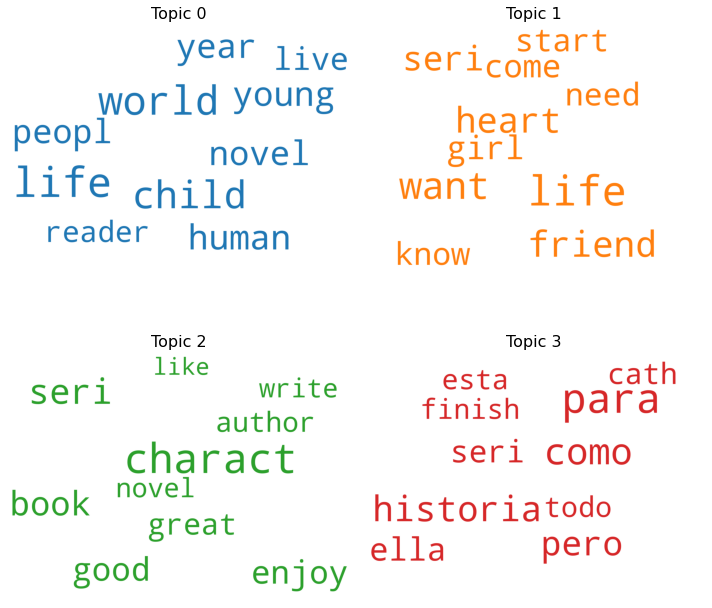

In [56]:
build_wordcloud(lda_model)

In [38]:
# Running LDA using TF-I
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.011*"wait" + 0.010*"amaz" + 0.009*"finish" + 0.005*"seri" + 0.004*"book" + 0.004*"absolut" + 0.004*"good" + 0.003*"edit" + 0.003*"author" + 0.003*"great"
Topic: 1 Word: 0.004*"seri" + 0.004*"charact" + 0.004*"great" + 0.004*"enjoy" + 0.004*"good" + 0.003*"book" + 0.003*"life" + 0.003*"author" + 0.003*"novel" + 0.003*"write"
Topic: 2 Word: 0.010*"seri" + 0.007*"enjoy" + 0.006*"fal" + 0.005*"disappoint" + 0.004*"follow" + 0.003*"need" + 0.003*"trilog" + 0.002*"good" + 0.002*"favourit" + 0.002*"damn"
Topic: 3 Word: 0.014*"great" + 0.006*"excel" + 0.004*"seri" + 0.004*"slow" + 0.003*"wish" + 0.002*"good" + 0.002*"hanger" + 0.002*"sequel" + 0.002*"book" + 0.002*"depress"
Topic: 4 Word: 0.004*"audiobook" + 0.004*"brilliant" + 0.003*"predict" + 0.003*"bore" + 0.003*"seri" + 0.002*"kellan" + 0.002*"good" + 0.002*"enjoy" + 0.002*"love" + 0.002*"charact"
Topic: 5 Word: 0.013*"good" + 0.009*"favorit" + 0.006*"soon" + 0.004*"like" + 0.003*"short" + 0.003*"sweet" + 0.003*"come" + 0

In [39]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))



Score: 0.9129613041877747	 
Topic: 0.004*"seri" + 0.004*"charact" + 0.004*"great" + 0.004*"enjoy" + 0.004*"good" + 0.003*"book" + 0.003*"life" + 0.003*"author" + 0.003*"novel" + 0.003*"write"

Score: 0.06920141726732254	 
Topic: 0.006*"cute" + 0.004*"best" + 0.004*"seri" + 0.003*"wonder" + 0.003*"great" + 0.003*"good" + 0.003*"fantast" + 0.003*"heart" + 0.003*"beauti" + 0.003*"book"


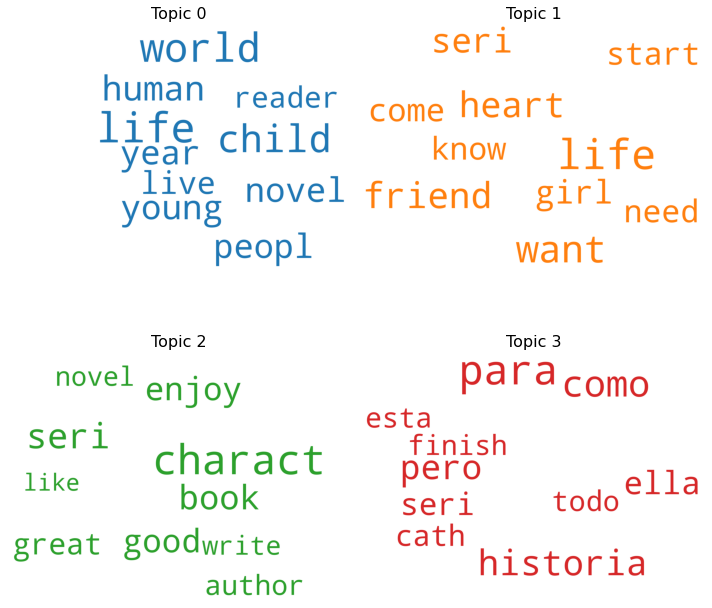

In [71]:
build_wordcloud(lda_model)

In [40]:
unseen_document = ' i was bored'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.549918532371521	 Topic: 0.021*"charact" + 0.014*"seri" + 0.013*"book" + 0.012*"good" + 0.012*"enjoy"
Score: 0.050024617463350296	 Topic: 0.013*"para" + 0.010*"como" + 0.010*"historia" + 0.009*"pero" + 0.008*"ella"
Score: 0.050009820610284805	 Topic: 0.010*"peopl" + 0.006*"stori" + 0.005*"author" + 0.004*"life" + 0.004*"person"
Score: 0.050008147954940796	 Topic: 0.020*"life" + 0.010*"famili" + 0.006*"peopl" + 0.006*"amaz" + 0.005*"write"
Score: 0.0500076524913311	 Topic: 0.017*"write" + 0.010*"star" + 0.008*"good" + 0.007*"work" + 0.007*"beauti"
Score: 0.05000728741288185	 Topic: 0.018*"vampir" + 0.009*"seri" + 0.008*"witch" + 0.007*"lili" + 0.006*"cute"
Score: 0.05000702291727066	 Topic: 0.009*"life" + 0.007*"want" + 0.007*"friend" + 0.006*"heart" + 0.006*"seri"
Score: 0.05000618100166321	 Topic: 0.014*"mysteri" + 0.010*"seri" + 0.010*"murder" + 0.007*"novel" + 0.006*"enjoy"
Score: 0.050005946308374405	 Topic: 0.009*"life" + 0.008*"world" + 0.007*"child" + 0.006*"human" + 0.0

In [77]:
#adapted from source: https://towardsdatascience.com/topic-modeling-with-nlp-on-amazon-reviews-an-application-of-latent-dirichlet-allocation-lda-ae42a4c8b369
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if     is_noun(pos)]
    return ' '.join(all_nouns)


[nltk_data] Downloading package punkt to /Users/aanyaashi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aanyaashi/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [78]:
#Started analyzing to see of there are differences in the models without nouns

data_nouns = pd.DataFrame(df_clean_desc.review_text.apply(nouns))
data_nouns


,review_text
0,ridicul histor mistak check minut googl search mccray rome bce eat tomato potato item europ centuri pasta arriv itali marco return china centuri mccray idea name rome julius caesar name name daughter julia wife wife wife porcia catoni servillia star
1,lust demon demon heart mate life virgin end gabe mate gabe type fae kind chosen gabe quit work relationship citi gabe innoc okay someth summari continu seri jump right
2,
3,attent
4,part chang idea happen differ sherlock
...,...
76823,wow non fiction reader typic escap amaz eye pacif portion wwii prologu recommend
76824,home sweet girl home holiday run conner debut misti matthew
76825,idea engag addict disturb fellow reader taboo taboo stomach tragedi ruin whatev end happili rug pull abus littl girl creat product troubl paradis littl truli place pure protect consequ veil pierc brutal dirti world
76826,water seri excel tomb name martha book seri charact lessor isa martha romanc time water seri fiction
